In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import norm, kurtosis

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'coding/' + 'Ion-Switching/'

In [2]:
def addfeatures( df1, window, direction = 0 ):
    suffix = 'back'
    if ( direction == 1):
        suffix = 'front'
    df1["rolling_" + suffix] = df1['signal'].rolling(window=window).mean()
    df1['signal_diff_' + suffix ]=df1['signal']-df1["rolling_" + suffix]
    df1["rolling_std_"  + suffix] = df1['signal'].rolling(window=window).std()
    df1.loc[:,'signal_diff_' + suffix + '_norm'] = df1['signal_diff_' + suffix ] - df1['signal_diff_' + suffix].mean()

def prepare( df, sampling, window = 1 ):    
    addfeatures( df, int(window/sampling), direction = -1 )    
    df = df[::-1].copy()
    addfeatures( df, int(window/sampling), direction = 1 )
    df = df[::-1].copy()
    df = df.dropna()    
    df = df.set_index(['time'])
    df['rolling_diff']=df['rolling_front']-df['rolling_back']
    return df

In [4]:
trainraw = pd.read_csv('train.csv')
testraw = pd.read_csv('test.csv')


sampling = 0.0001
batchsize = 50
n = int(batchsize/sampling);
totalbatches = int(len(trainraw)//n)

train = prepare( trainraw, sampling, window = 1  )
test = prepare( testraw, sampling, window = 1  )

#train = train.iloc[np.random.permutation(len(train))]
#train.reset_index(inplace=True, drop=True)

batches = []
for i in range(0,totalbatches):
    sample = trainraw.iloc[ i*n : min((i+1)*n, len(trainraw)+1) ]
    prep_sample = prepare(sample, sampling, window = 1)
    batches.append( prep_sample )

m = int(20/sampling) #we use a smaller window of sampling in test data
testbatches = int(len(testraw)//m)
test_batches = []
for i in range(0,testbatches):
    sample = testraw.iloc[ i*m : min((i+1)*m, len(trainraw)+1) ]
    prep_sample = prepare(sample, sampling, window = 1)
    test_batches.append( prep_sample )

/Users/mengmengcai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/mengmengcai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/mengmengcai/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [9]:
train.head()
batches[9].head()
len(batches)

10

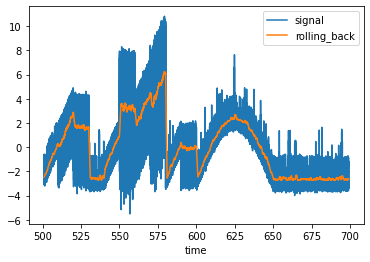

In [0]:
test[['signal','rolling_back']].plot()

Next, we look at the histogram of moving averages of each batch. It turns out each batch comprises of a series of Gaussian distributions.

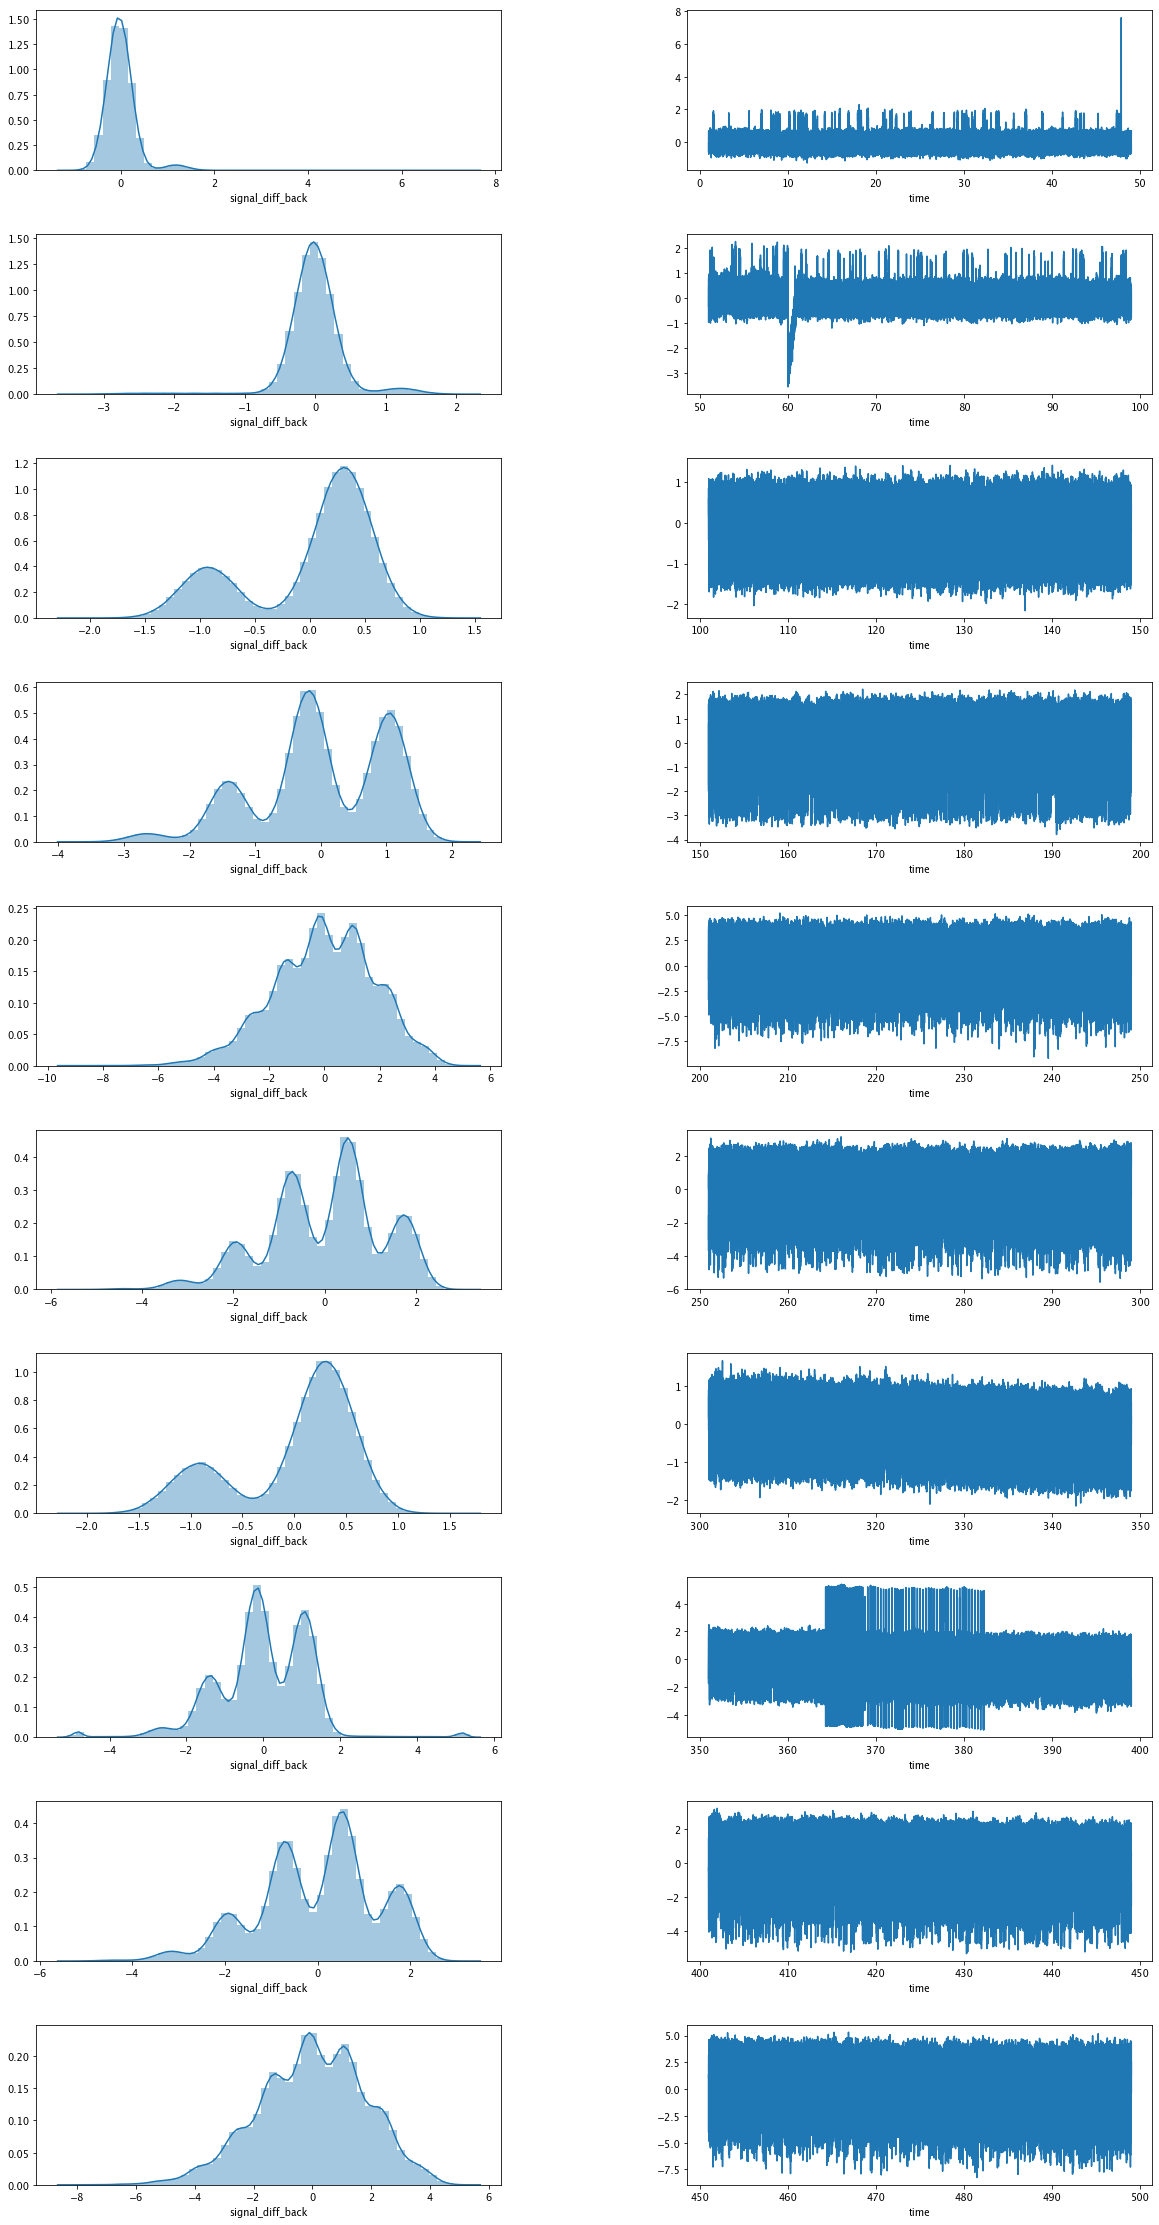

In [5]:
fig = plt.figure(figsize = (20,40))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

l = len(batches)
i = 1

for batch in batches[:l]:
    ax = fig.add_subplot(l, 2, i)
    i+=1
    sns.distplot(batch['signal_diff_back'],ax=ax)
    ax = fig.add_subplot(l, 2, i)
    i+=1
    batch['signal_diff_back'].plot(ax=ax)
plt.show()

In [6]:
batch_stats = []

for batchid in range(l):
  batch = batches[batchid]
  channels = sorted(batch['open_channels'].unique())
  d = dict()
  for channel in channels:
      temp = batch[batch['open_channels'] == channel]
      x = temp['signal_diff_back']

      mean, std = np.mean(x), np.std(x)
      d[channel] = (mean, std)
  batch_stats.append(d)

#batch_stats  

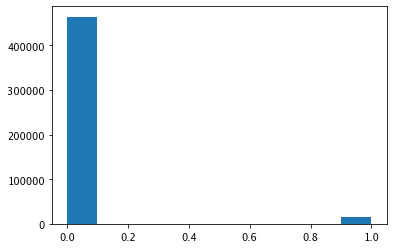

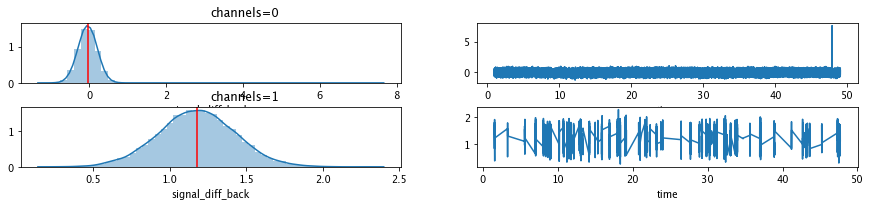

In [7]:
batchid=0
batch = batches[batchid]

channels = sorted(batch['open_channels'].unique())

i = 1

plt.hist(batch['open_channels'])
plt.show()

fig = plt.figure(figsize = (15,15))
fig.subplots_adjust(hspace=0.4)
for channel in channels:
    dfsig = batch[batch['open_channels']==channel]
    ax = fig.add_subplot(l, 2, i)
    ax.set_title('channels='+ str(channel),{'horizontalalignment': 'left'})
    i+=1
    
    x = dfsig['signal_diff_back']
    sns.distplot(x, ax=ax)
    
#    x = ax.lines[0].get_xdata()
#    y = ax.lines[0].get_ydata()
    mean, std_dev = np.mean(x), np.std(x)
    
    plt.axvline(mean, color='red')
#    ax.lines[0].remove()
    
    ax = fig.add_subplot(l, 2, i)
    i+=1
    dfsig['signal_diff_back'].plot(ax=ax)
    
plt.show()

It seems that each signal (or precisely, moving average of it with its previous values in the rolling window) belongs to a normal distributions. So our next step is to use Bayesian inference to infer the probability of a new signal belongs to each of the normal distribution.

Now, let's take a look at test data

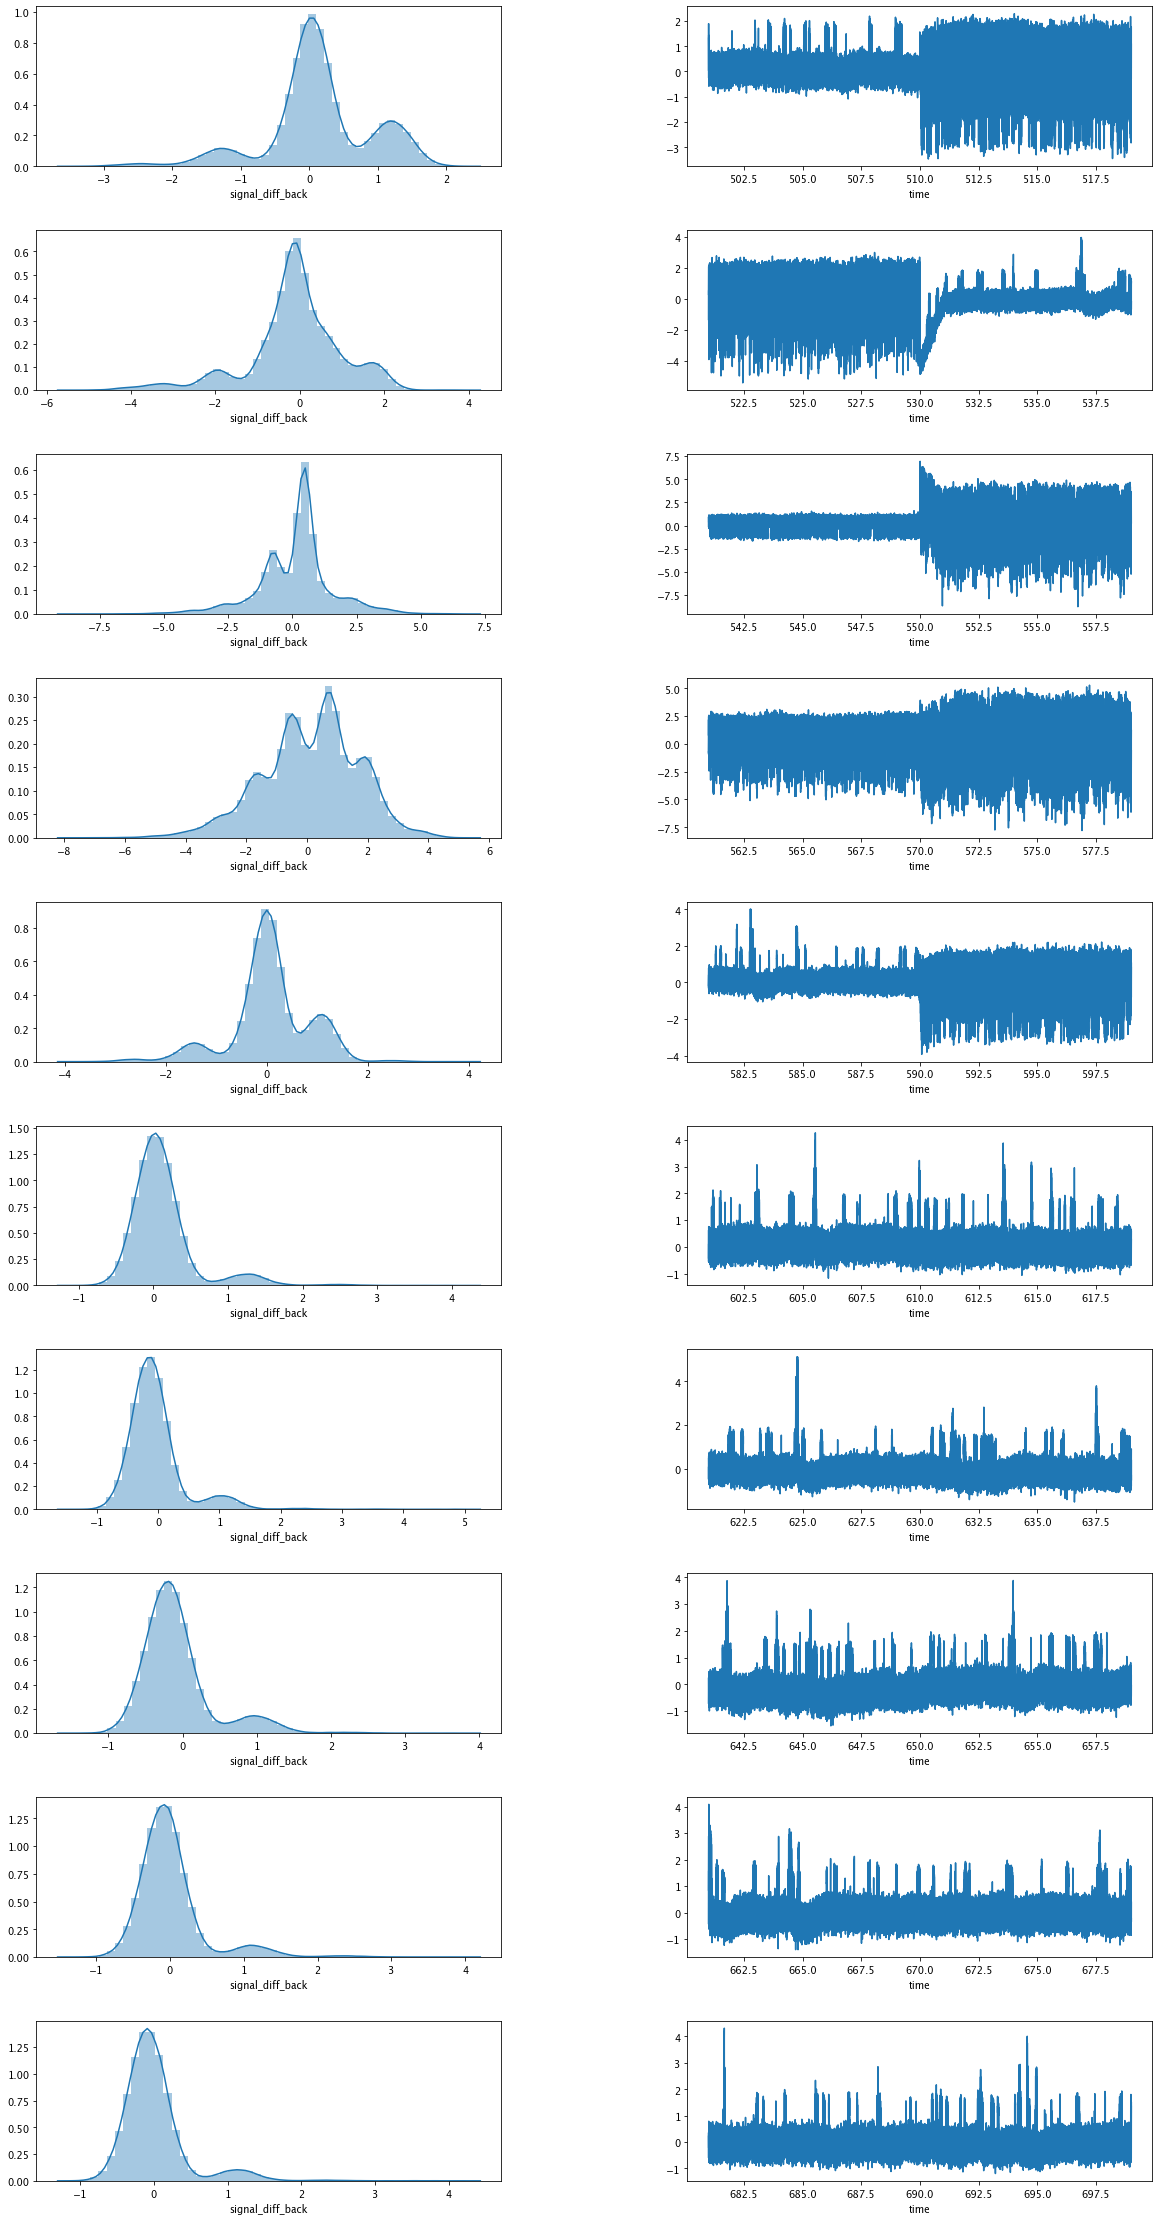

In [8]:
fig = plt.figure(figsize = (20,40))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

k = len(test_batches)
i = 1

for test_batch in test_batches:
    ax = fig.add_subplot(k, 2, i)
    i+=1
    sns.distplot(test_batch['signal_diff_back'],ax=ax)
    ax = fig.add_subplot(k, 2, i)
    i+=1
    test_batch['signal_diff_back'].plot(ax=ax)
plt.show()

What I'm gonna do next is a combination of quant and non-quant work. Firstly I'm eye-balling the distributions in test batches and identifies similar patterns between a test batch and a training batch, e.g, test batches 2, 3 and training batch 0.

Then we apply bayesian MCMC to training batch (e.g, 0 for test batch 2/3) to determine the prior distribution of channels as well as mean and std of each Gaussian.

In [9]:
def evaluate(tensors):
    if tf.executing_eagerly():
         return tf.nest.pack_sequence_as(
             tensors,
             [t.numpy() if tf.is_tensor(t) else t
             for t in tf.nest.flatten(tensors)])
    with tf.Session() as sess:
        return sess.run(tensors)

In [10]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

batchid = 0
stats = batch_stats[batchid]
channels = sorted(batch['open_channels'].unique())
n = len(channels)

means, stds = [ stats[ind][0] for ind in stats ], [ stats[ind][1] for ind in stats ]
errors = [1 for _ in range(len(stats))] 
ps, a, b = [], 0.0, 1.0

for ind in range(n-1):
    p = tfd.Uniform(name='p'+str(ind+1), low=a, high=b ).sample()
    ps.append(p)
    b -= p
ps.append(b)
p1 = tf.stack(ps)
rv_assignments = tfd.Categorical(name='assignment', probs=p1)
assignments = rv_assignments.sample(sample_shape=batch.shape[0])

[p1_, assignments_] = evaluate([p1, assignments])

print("prior assignment", p1_)
print(assignments_)  
print(means)
print(stds)


prior assignment [0.71633685 0.28366315]
[0 0 1 ... 0 1 0]
[-0.03961609852724166, 1.1777646665148027]
[0.25100851487332904, 0.2512244610006884]


In [11]:
stats

{0: (-0.03961609852724166, 0.25100851487332904),
 1: (1.1777646665148027, 0.2512244610006884)}

In [12]:
rv_centers = tfd.Normal(name='centers', loc = means, scale = errors)
#    taus    = pm.Normal('std dev', np.asarray(stds),  np.asarray(errors), shape=n)
rv_taus    = tfd.Uniform(name='std dev', low=0.0,  high=1.0)

taus = rv_taus.sample(sample_shape = n)
centers = rv_centers.sample()

#random sample to simulate the situation
assignments = rv_assignments.sample(sample_shape=10)

rv_observations = tfd.MixtureSameFamily(
    mixture_distribution = rv_assignments,
    components_distribution = tfd.Normal(
        loc=centers,
        scale=taus
    )
)
observations = rv_observations.sample(sample_shape=10)

[assignments_, observations_, centers_, taus_] = evaluate(
    [assignments, observations, centers, taus]
)

print("simulated data: ", observations_[:4], "...")
print("Random assignments: ", assignments_[:4], "...")
print("Assigned center: ", centers_[:4], "...")
print("Assigned standard deviation: ", taus_[:4],"...")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/mengmengcai/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-408027560281>", line 15, in <module>
    scale=taus
  File "<decorator-gen-231>", line 2, in __init__
  File "/Users/mengmengcai/opt/anaconda3/lib/python3.7/site-packages/tensorflow_probability/python/distributions/distribution.py", line 276, in wrapped_init
    default_init(self_, *args, **kwargs)
  File "/Users/mengmengcai/opt/anaconda3/lib/python3.7/site-packages/tensorflow_probability/python/distributions/normal.py", line 134, in __init__
    dtype = dtype_util.common_dtype([loc, scale], dtype_hint=tf.float32)
  File "/Users/mengmengcai/opt/anaconda3/lib/python3.7/site-packages/tensorflow_probability/python/internal/dtype_util.py", line 84, in common_dtype
    'Found incompatible dtypes, {} and {}.'.format(dtype, dt))
TypeError: Found incompati

TypeError: Found incompatible dtypes, <class 'numpy.float64'> and <class 'numpy.float32'>.

The following writes a joint log prob function which will be used in HMC later.

In [0]:
def joint_log_prob(data_, sample_probs, sample_centers, sample_taus):
  #create mixture of Gaussians

  lows, highs = [0.0 for _ in range(n)], [1.0 for _ in range(n)]

  rv_prob = tfd.Uniform(name='rv_prob', low=0.0, high=1.0)

  proba = []
  #below only works for n=2, for n > 2 need to make all probs add up to 1.
  for prob in sample_probs:
    proba.append(prob)
  proba.append(1-sum(sample_probs))
  rv_assignments = tfd.Categorical(probs=tf.stack(proba))

  rv_centers = tfd.Normal(name='centers', loc = means, scale = errors)
  rv_taus    = tfd.Uniform(name='std dev', low=lows,  high=highs) 

  rv_observations = tfd.MixtureSameFamily(
      mixture_distribution=rv_assignments,
      components_distribution=tfd.Normal(
          loc=sample_centers,
          scale=sample_taus
      )
  )

  ret = (
      tf.reduce_sum(rv_observations.log_prob(data_))      # Sum over samples.
      + tf.reduce_sum(rv_centers.log_prob(sample_centers)) # Sum over components.
      + tf.reduce_sum(rv_taus.log_prob(sample_taus))         # Sum over components.
  )

  for prob in proba[::-1]:
    ret = ( rv_prob.log_prob(prob) + ret )
  return ret
 

The following code builds a Hamiltonian Monte-Carlo (HMC) model.

In [19]:
number_of_steps=50000 #@param {type:"slider", min:0, max:50000, step:1000}
burnin = 10000 #@param {type:"slider", min:0, max:10000, step:100}
num_leapfrog_steps=1

init_probs = [ 1.0/n for _ in range(n-1) ]
#set chains initial states
initial_chain_state = [
  tf.constant(init_probs, name='init_probs'),
  tf.constant(means, name='init_centers'),
  tf.constant(stds,  name='init_taus')
]

# Since MCMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Identity(),       # Maps R to R.
    tfp.bijectors.Identity(),       # Maps R to R.
    tfp.bijectors.Identity(),       # Maps R to R.
]

# Define a closure over our joint_log_prob.
unnormalized_posterior_log_prob = lambda *args: joint_log_prob(batch['signal_diff_back'], *args)

# Initialize the step_size. (It will be automatically adapted.)
with tf.compat.v1.variable_scope(tf.compat.v1.get_variable_scope(), reuse=tf.compat.v1.AUTO_REUSE):
    step_size = tf.compat.v1.get_variable(
        name='step_size',
        initializer=tf.constant(0.05, dtype=tf.float32),
        trainable=False,
        use_resource=True
    )

# Defining the HMC
hmc=tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        num_leapfrog_steps=num_leapfrog_steps,
        step_size=step_size,
        step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(num_adaptation_steps=int(burnin * 0.8)),
        state_gradients_are_stopped=True),
    bijector=unconstraining_bijectors)

# Sample from the chain.
[
    posterior_prob,
    posterior_centers,
    posterior_taus
], kernel_results = tfp.mcmc.sample_chain(
    num_results=number_of_steps,
    num_burnin_steps=burnin,
    current_state=initial_chain_state,
    kernel=hmc)

# Initialize any created variables.
init_g = tf.compat.v1.global_variables_initializer()
init_l = tf.compat.v1.local_variables_initializer()    

Instructions for updating:
Use tfp.mcmc.SimpleStepSizeAdaptation instead.


/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/internal/util.py:521: UserWarning: `step_size` is not a `tf.Tensor`, Python number, or Numpy array. If this parameter is mutable (e.g., a `tf.Variable`), then the behavior implied by `store_parameters_in_results` will silently change on 2019-08-01. Please consult the docstring for `store_parameters_in_results` details and use `store_parameters_in_results=True` to silence this warning.
  param_name))
/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


In [23]:
evaluate(init_g)
evaluate(init_l)
[
    posterior_prob_,
    posterior_centers_,
    posterior_taus_,
    kernel_results_
] = evaluate([
    posterior_prob,
    posterior_centers,
    posterior_taus,
    kernel_results
])
    
new_step_size_initializer_ = kernel_results_.inner_results.is_accepted.mean()
print("acceptance rate: {}".format(
    new_step_size_initializer_))
new_step_size_initializer_
print("final step size: {}".format(
    kernel_results_.inner_results.extra.step_size_assign[-100:].mean()))

acceptance rate: 0.65618
final step size: 0.00037398532731458545


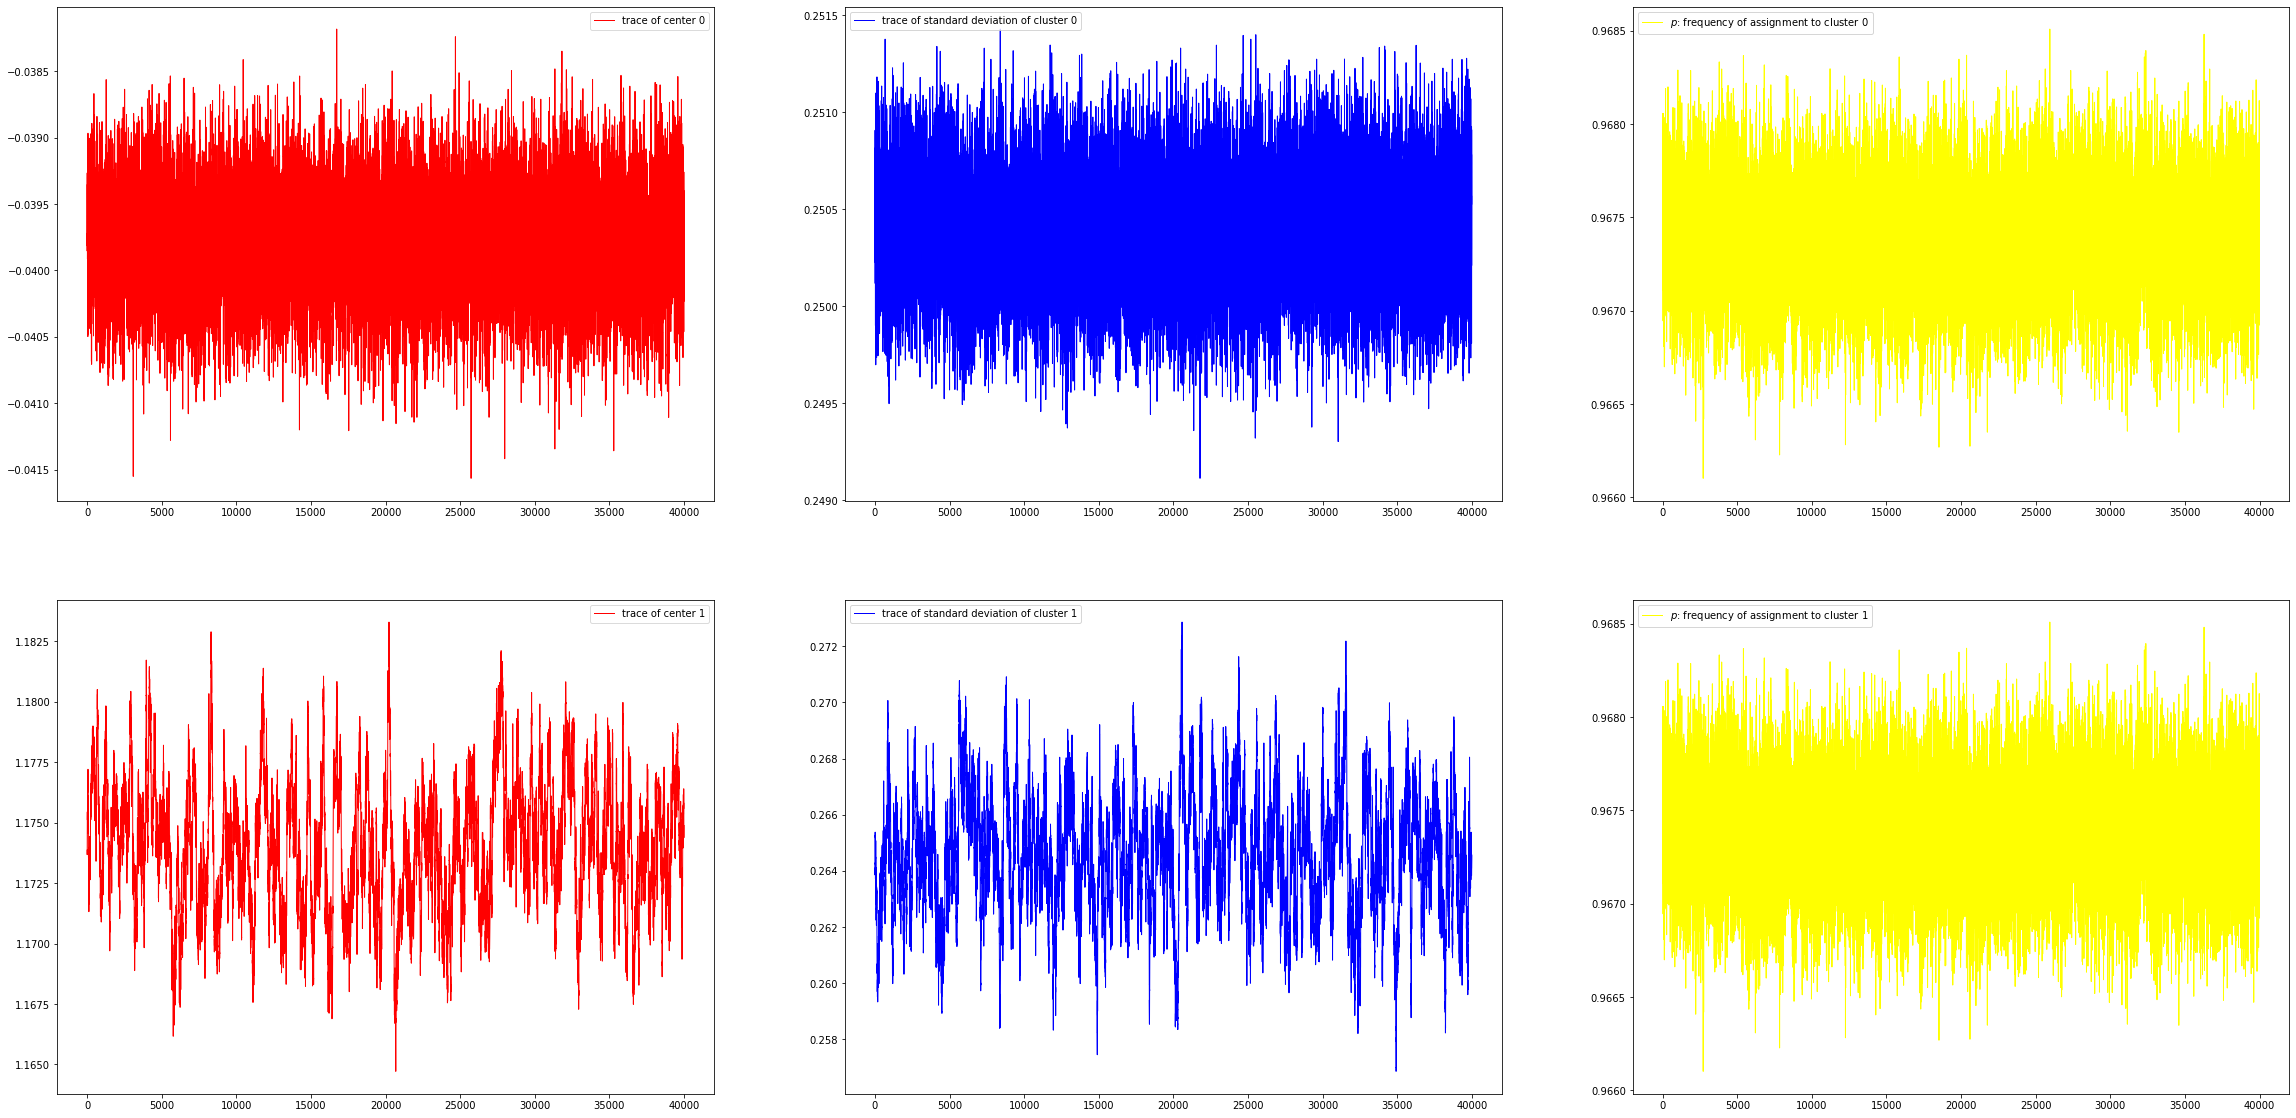

array([[0.9671078],
       [0.96711  ]], dtype=float32)

In [25]:
fig = plt.figure(figsize = (40,20))
lw = 1

center_trace = posterior_centers_[10000:, :]
std_trace = posterior_taus_[10000:, :]
p_trace = posterior_prob_[10000:, :]

# for pretty colors later in the book.
#colors = ["#348ABD", "#A60628"] if center_trace[-1, 0] > center_trace[-1, 1] \
#    else ["#A60628", "#348ABD"]
j = 1
for i in range(n):
    ax = fig.add_subplot(n, 3, j)
    ax.plot(center_trace[:, i], label="trace of center " + str(i), c='red', lw=lw)
    leg = ax.legend(loc="upper right")
    leg.get_frame().set_alpha(0.7)
    j += 1
    
    ax = fig.add_subplot(n, 3, j)
    ax.plot(std_trace[:, i], label="trace of standard deviation of cluster " + str(i),
         c='blue', lw=lw)
    ax.legend(loc="upper left")
    j += 1

    ax = fig.add_subplot(n, 3, j)
    ax.plot(p_trace[:, 0], label="$p$: frequency of assignment to cluster " + str(i),
         color='yellow', lw=lw)
    ax.legend(loc="upper left")
    j += 1

plt.show()
p_trace[:2, :]
#center_trace[:100, 1]

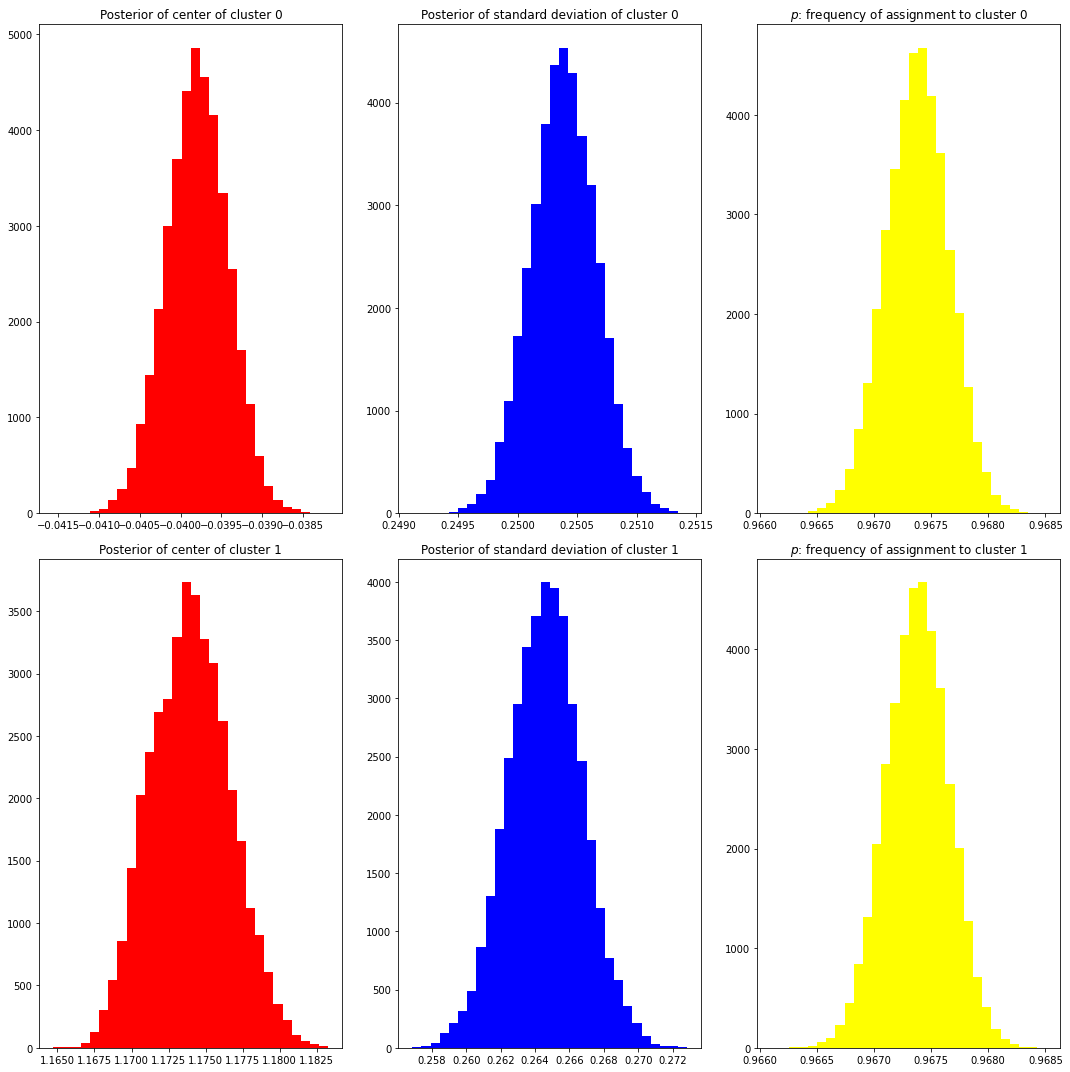

In [26]:
fig = plt.figure(figsize = (15,15))

j = 1
for i in range(n):
    ax = fig.add_subplot(n, 3, j)
    plt.title("Posterior of center of cluster " + str(i))
    plt.hist(center_trace[:, i], color='r', bins=30,
             histtype="stepfilled")
    j += 1
    
    ax = fig.add_subplot(n, 3, j)
    plt.title("Posterior of standard deviation of cluster " + str(i))
    plt.hist(std_trace[:, i], color='b', bins=30,
             histtype="stepfilled")
    j += 1
    
    ax = fig.add_subplot(n, 3, j)
    plt.title("$p$: frequency of assignment to cluster " + str(i))
    plt.hist(p_trace[:, 0], color='yellow', bins=30, histtype="stepfilled")
    
    j += 1    
    # plt.autoscale(tight=True)

plt.tight_layout()

In [27]:
number_of_steps=50000 #@param {type:"slider", min:0, max:50000, step:1000}
burnin=2000 #@param {type:"slider", min:0, max:2000, step:100}

# Set the chain's start state.
initial_chain_state = [
    tf.constant(posterior_prob_[-1], name='init_probs_2'),
    tf.constant(posterior_centers_[-1], name='init_centers_2'),
    tf.constant(posterior_taus_[-1], name='init_taus_2')
]


# Initialize the step_size. (It will be automatically adapted.)
with tf.compat.v1.variable_scope(tf.compat.v1.get_variable_scope(), reuse=tf.compat.v1.AUTO_REUSE):
    step_size = tf.compat.v1.get_variable(
        name='step_size_2',
        initializer=tf.constant(0.01, dtype=tf.float32),
        trainable=False,
        use_resource=True
    )

# Defining the HMC
hmc=tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_posterior_log_prob,
        num_leapfrog_steps=num_leapfrog_steps,
        step_size=step_size,
        step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(num_adaptation_steps=int(burnin * 0.8)),
        state_gradients_are_stopped=True),
    bijector=unconstraining_bijectors)

# Sample from the chain.
[
    posterior_prob_2,
    posterior_centers_2,
    posterior_taus_2
], kernel_results = tfp.mcmc.sample_chain(
    num_results=number_of_steps,
    num_burnin_steps=burnin,
    current_state=initial_chain_state,
    kernel=hmc)


/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/internal/util.py:521: UserWarning: `step_size` is not a `tf.Tensor`, Python number, or Numpy array. If this parameter is mutable (e.g., a `tf.Variable`), then the behavior implied by `store_parameters_in_results` will silently change on 2019-08-01. Please consult the docstring for `store_parameters_in_results` details and use `store_parameters_in_results=True` to silence this warning.
  param_name))
/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


AttributeError: ignored

In [28]:
# Initialize any created variables.
init_g = tf.compat.v1.global_variables_initializer()
init_l = tf.compat.v1.local_variables_initializer()

evaluate(init_g)
evaluate(init_l)
[
    posterior_prob_2_,
    posterior_centers_2_,
    posterior_taus_2_,
    kernel_results_
] = evaluate([
    posterior_prob_2,
    posterior_centers_2,
    posterior_taus_2,
    kernel_results
])

print("acceptance rate: {}".format(
    kernel_results_.inner_results.is_accepted.mean()))
new_step_size_initializer_
print("final step size: {}".format(
    kernel_results_.inner_results.extra.step_size_assign[-100:].mean()))

acceptance rate: 0.67362
final step size: 0.000414152629673481


Here, we noticed that conditional upon certain channel the signals distribution is Gaussian. So we are planning to apply Bayesian analysis. Recall that Bayesian analysis depends on the Bayes theorem:
$$
\mathbb{P}(channel|signal) = \frac{\mathbb{P}(signal|channel)\times\mathbb{P}(channel)}{\mathbb{P}(signal)}.
$$
So for each test data/signal, we will categorify it to the channel that makes $\mathbb{P}(channel_i|signal)$ biggest. Since the demoninators are all the same, we may only compare
$$
\mathbb{P}(signal|channel_i)\times\mathbb{P}(channel_i).
$$

In [27]:
from scipy import stats
post_stats = []
p_sup = 1
for i in range(n):
  if i != n-1:
    mean, std, p = center_trace[:, i].mean(), std_trace[:, i].mean(), stats.mode(p_trace[:, 0])[0][0]
    p_sup -= stats.mode(p_trace[:, 0])[0][0]
  else:
    mean, std, p = center_trace[:, i].mean(), std_trace[:, i].mean(), p_sup
  post_stats.append({'mean':mean, 'std':std, 'p':p})
post_stats

[{'mean': -0.039795514, 'p': 0.96742004, 'std': 0.25038707},
 {'mean': 1.1739893, 'p': 0.03257995843887329, 'std': 0.26459053}]

In [1]:
from scipy.stats import norm

test_batchid = -2
test_batch = test_batches[test_batchid]
test_signals = test_batch['signal_diff_back'].to_numpy()

test_channels = []

for m, signal in enumerate(test_signals):
#  res, dist = None, -float('inf')
#  for i, stat in enumerate(post_stats):
#    loc, scale, prior = stat['mean'], stat['std'], stat['p']
#    v = norm.cdf(signal, loc=loc, scale=scale)*prior
#    p_trace_sup = np.ones((p_trace.shape[0], 1))
#    if i != n-1:
#      p_trace_sup = p_trace_sup -  p_trace[:, i]
#      temp = p_trace[:, i] * evaluate(tfd.Normal(loc=center_trace[:, i], scale=std_trace[:, i]).log_prob(signal))
#    else:
#      temp = p_trace_sup * evaluate(tfd.Normal(loc=center_trace[:, i], scale=std_trace[:, i]).log_prob(signal))
  ps = p_trace[:, 0]
  v = ( p_trace * evaluate(tfd.Normal(loc=center_trace[:, 0], scale=std_trace[:, 0]).log_prob(signal)) ) > \
      ( (1 - p_trace) * evaluate(tfd.Normal(loc=center_trace[:, 1], scale=std_trace[:, 1]).log_prob(signal)) )
  res = 0 if v.mean() > 0.5 else 1

  if m%10000 == 0:
    print( 'm = ', m )
    print( 'signal = ', signal )
    print( 'channel = ', res )
    print( 'proba = ', ps.mean() )
  test_channels.append(res)


NameError: ignored

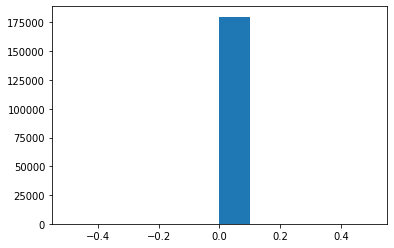

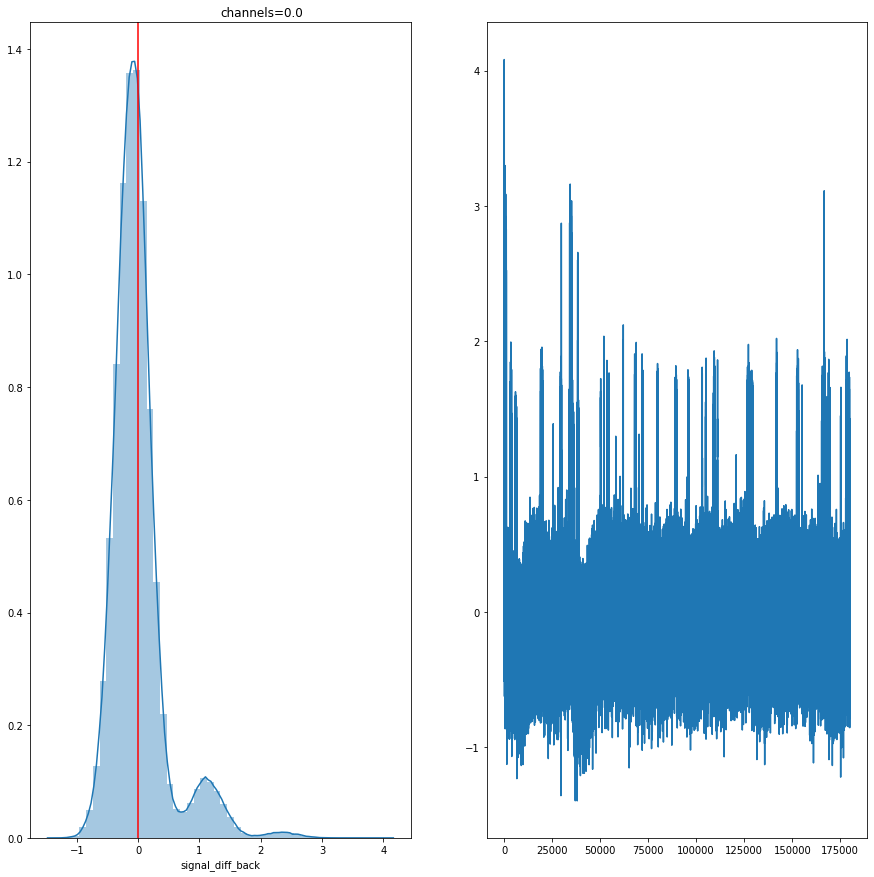

In [80]:
data = np.c_[test_signals, test_channels]
data = np.asarray(data)
df = pd.DataFrame(data=data, columns=['signal_diff_back', 'open_channels'])

plt.hist(df['open_channels'])
plt.show()

tests = sorted(df['open_channels'].unique())
size = len(tests)

fig = plt.figure(figsize = (15,15))
fig.subplots_adjust(hspace=0.4)

i = 1
for channel in tests:
    dfsig = df[df['open_channels']==channel]
    ax = fig.add_subplot(size, 2, i)
    ax.set_title('channels='+ str(channel),{'horizontalalignment': 'left'})
    i+=1
    
    x = dfsig['signal_diff_back']
    sns.distplot(x, ax=ax)
    
#    x = ax.lines[0].get_xdata()
#    y = ax.lines[0].get_ydata()
    mean, std_dev = np.mean(x), np.std(x)
    
    plt.axvline(mean, color='red')
#    ax.lines[0].remove()
    
    ax = fig.add_subplot(size, 2, i)
    i+=1
    dfsig['signal_diff_back'].plot(ax=ax)
    
plt.show()